In [6]:
import gym
from gym import envs
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd

from random import sample

## 1) Defining Functions

#### 1.1) Initialising state values

In [29]:
def initialise_state_values(env, initialisation_type =  'zeros'):
      
        '''This function initialises the state value functions'''
        
    if(initialisation_type=='zeros'):
        V = np.zeros(env.nS, dtype = 'float')
        return V

#### 1.2) Bellman Equations

In [78]:
def bellman_expectation(env, policy, V0, gamma):
    
    '''This function performs bellman '''
    P = env.P
    V1 = initialise_state_values(env, initialisation_type = 'zeros')
    
    for state in range(env.nS):
        total_expected_reward = 0
        
        for action, p_action in enumerate(policy[state]):
            discounted_reward = 0
            
            for action_by_environment in P[state][action]:
                prob = action_by_environment[0]
                next_state = action_by_environment[1]
                reward = action_by_environment[2]
                discounted_reward+=(prob*(reward + gamma*V0[next_state]))
            
            total_expected_reward+=(p_action*discounted_reward)
        
        V1[state] = total_expected_reward
        
    return V1



def bellman_maximization(env,V0, gamma):
    '''This Function performs Bellman maximization'''
    
    P = env.P
    greedy_policy = np.zeros(shape = (env.nS, env.nA), dtype = 'float')
    V1 = initialise_state_values(env, initialisation_type = 'zeros')
    
    for state in range(env.nS):
        max_expected_reward = 0
        optimal_action = -1
        
        for action in range(env.nA):
            discounted_reward = 0
            
            for action_by_environment in P[state][action]:
                prob = action_by_environment[0]
                next_state = action_by_environment[1]
                reward = action_by_environment[2]
                discounted_reward+=(prob*(reward + gamma*V0[next_state]))
            
            if(discounted_reward>max_expected_reward):
                max_expected_reward = discounted_reward
                optimal_action = action
        
        V1[state] = max_expected_reward
        greedy_policy[state][optimal_action] = 1
        
    return V1, greedy_policy



def evaluate_greedy(env, V0, gamma):
    '''This function evaluates greedy policy''' 
    V1, greedy_policy = bellman_maximization(env, V0, gamma)
    return greedy_policy

#### 1.3) Emperically Evaluating the policy

In [207]:
def emperical_evaluate_policy(env, policy, MAX_EPISODES = 500, MAX_LENGTH = 1000):
    '''This function eperically evaluates a policy''' 
    reward_per_episode = []
    for episode in range(MAX_EPISODES):
        current_state = env.reset()
        current_total_reward = 0
        iterations = 0
        episode_ended = False
        
        while(iterations<MAX_LENGTH and episode_ended==False):
            action = np.random.choice(np.arange(env.nA), p = policy[current_state])
            next_state, reward, Done, info = env.step(action)
            
            current_state = next_state
            current_total_reward+=reward
            iterations+=1
            episode_ended = Done
        
        reward_per_episode.append(current_total_reward)
        
    return np.mean(reward_per_episode)


#### 1.4) Policy Evaluation and inducing greedy Policy

In [339]:
def iterative_policy_evaluation(env, policy, V0, epsilon=.001, gamma=1):
    '''This function performs iterative Policy Evaluation'''   

    V1 = bellman_expectation(env, policy, V0, gamma)
    steps = 1
    inf_norm = np.max(abs(V1 - V0))
    #while((inf_norm> epsilon*(1-gamma)/(2*gamma))  if gamma!=1 else (inf_norm>epsilon)):
    while(inf_norm>epsilon):
        steps+=1
        V0 = V1
        V1 = bellman_expectation(env, policy, V0, gamma)
        inf_norm = np.max(abs(V1 - V0))
        
    return V1, steps



def modified_policy_evaluation(env, policy, V0, epsilon = .001, gamma = 1, m=3):
    '''This function performs MPI'''
    V1 = bellman_expectation(env, policy, V0, gamma)
    steps = 1
    inf_norm = np.max(abs(V1 - V0))
    while(steps<=m):
    #while(steps<=m and (inf_norm> epsilon*(1-gamma)/(2*gamma))  if gamma!=1 else (inf_norm>epsilon)):
        steps+=1
        V0 = V1
        V1 = bellman_expectation(env, policy, V0, gamma)
        inf_norm = np.max(abs(V1 - V0))
        
    return V1, steps


def policy_evaluation(env, policy, V0, epsilon = .001, gamma = 1, policy_evaluation_method =['Iterative', np.inf]):
    
    '''This function evaluates a given type of policy evaluation method'''
    
    if(policy_evaluation_method[0]=='Iterative'):
        V1, steps = iterative_policy_evaluation(env, policy, V0, epsilon, gamma)
        return V1, steps
    
    if(policy_evaluation_method[0]=='Modified'):
        m = policy_evaluation_method[1]
        V1, steps = modified_policy_evaluation(env, policy, V0, epsilon, gamma, m)
        return V1, steps

#### 1.5) Policy Iteration for Optimal Value Function and Optimal  Policy

In [294]:
def policy_iteration(env, epsilon = .001, gamma = 1, policy_evaluation_method = ['Iterative', np.inf], MAX_EPISODES=500, MAX_LENGTH=1000):
   
    '''This function performs policy iteration'''
    internal_steps = []
    avg_reward = []
    policy = np.zeros(shape = (env.nS,env.nA), dtype = 'float')
    for state in range(env.nS):
        action = sample([x for x in range(0, env.nA)], 1)[0]
        policy[state][action] = 1                              # Initialising with a deterministic policy
        
    U0 = initialise_state_values(env, 'zeros')
    V1, policy_eval_steps = policy_evaluation(env, policy, U0, epsilon, gamma, policy_evaluation_method)
    internal_steps.append(policy_eval_steps)
    policy_iter_steps = 1
    U0,policy = bellman_maximization(env, V1, gamma)
    
    avg_estimated_reward = emperical_evaluate_policy(env, policy, MAX_EPISODES, MAX_LENGTH)
    avg_reward.append(avg_estimated_reward)
    
    #policy = evaluate_greedy(env,V1, gamma)
    inf_norm = np.max(abs(U0 - V1))
    
    #while((inf_norm> epsilon*(1-gamma)/(2*gamma))  if gamma!=1 else (inf_norm>epsilon)):
    while(inf_norm>epsilon):
        V1, policy_eval_steps = policy_evaluation(env, policy, U0, epsilon, gamma, policy_evaluation_method)
        internal_steps.append(policy_eval_steps)
        policy_iter_steps+=1
        U0,policy = bellman_maximization(env, V1, gamma)
        
        avg_estimated_reward = emperical_evaluate_policy(env, policy, MAX_EPISODES, MAX_LENGTH)
        avg_reward.append(avg_estimated_reward)
        
        #policy = evaluate_greedy(env, V1, gamma)
        inf_norm = np.max(abs(U0 - V1))
        
    return U0, policy_iter_steps, internal_steps, avg_reward
    

#### 1.6) Value Iteration for Optimal Value Function and Optimal Policy


In [328]:
def value_iteration(env, epsilon=0.001, gamma = 1, MAX_EPISODES = 500, MAX_LENGTH = 1000):
    '''This function performs value iteration'''
    #single_action_backups = []
    avg_reward = []
    V0 = initialise_state_values(env, 'zeros')
    V1, useless = bellman_maximization(env, V0, gamma)
    policy = evaluate_greedy(env, V1, gamma)
    avg_estimated_reward = emperical_evaluate_policy(env, policy, MAX_EPISODES, MAX_LENGTH)
    avg_reward.append(avg_estimated_reward)
    val_iter_steps = 1
    inf_norm = np.max(abs(V1 - V0))
    
    #while((inf_norm> epsilon*(1-gamma)/(2*gamma))  if gamma!=1 else (inf_norm>epsilon)):
    while(inf_norm>epsilon):
        V0 = V1
        V1, useless = bellman_maximization(env, V0,gamma)
        policy = evaluate_greedy(env, V1, gamma)
        avg_estimated_reward = emperical_evaluate_policy(env, policy, MAX_EPISODES, MAX_LENGTH)
        avg_reward.append(avg_estimated_reward)
        val_iter_steps+=1
        inf_norm = np.max(abs(V1 - V0))
        
    return V1, val_iter_steps, avg_reward

#### 1.7) GraphPlotting Functions

In [329]:
def plot_graphs(iterations, backups, avg_reward):
    '''Helper function to plot graphs'''
    plt.figure(1, figsize = (14,5))
    
    plt.subplot(121)
    plt.plot(iterations, avg_reward)
    plt.xlabel('Number of iterations')
    plt.ylabel('average reward for 500 episodes')
    plt.title('Quality of policy as a function of iteration')
    plt.grid()
    
    
    plt.subplot(122)
    plt.plot(backups, avg_reward)
    plt.xlabel('Number of backups')
    plt.ylabel('average reward for 500 episodes')
    plt.title('Quality of policy as a function of backups')
    plt.grid()
    plt.show()
    

## 2) Defining Environment Parameters

In [330]:
tollerance= 0.001
np.random.seed(5467)
env = gym.make('FrozenLake-v0',desc=None,map_name=None)
env.seed(48304)
env._max_episode_steps = 1000
MAX_EPISODES = 500
MAX_LENGTH = 1000
SA = env.nS * env.nA

## 3) Comparing VI , PI, MPI

#### 3.1) Value Iteration

In [331]:
optimal_value_function_VI, steps_VI, avg_reward_VI = value_iteration(env, .001, 1, MAX_EPISODES, MAX_LENGTH)

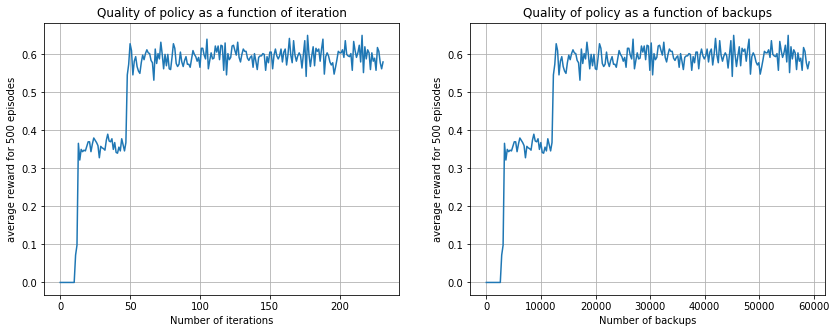

In [332]:
backups_VI = [SA*i for i in range(steps_VI)]
plot_graphs(np.arange(steps_VI), backups_VI, avg_reward_VI)

We can see that the number of iterations required for VI to converge is very high , approximately 232, which is 200% more than what it takes for PI to converge <br>

However when we look in terms of backup operations required, It takes 60,000 backups which is only 4 times more than what it took for PI

#### 3.2) Policy Iteration

In [337]:
optimal_value_function_PI, steps_PI, steps_PE, avg_reward_PI = policy_iteration(env, .001, 1, ['Iterative', np.inf], MAX_EPISODES, MAX_LENGTH)

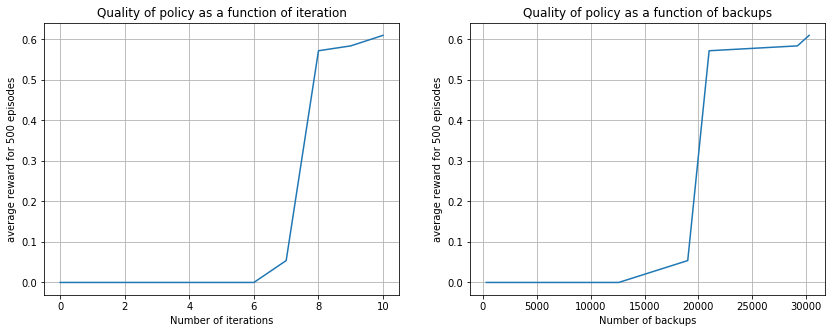

In [338]:
backups_PI = []
previous = 0
for i in steps_PE:
    backups_PI.append(previous + (SA+env.nS*i))
    previous = backups_PI[-1]
    
plot_graphs(np.arange(steps_PI), backups_PI, avg_reward_PI)

We can see that the number of iterations required for PI to converge is very low , approximately 10, which is way too less than what it takes for VI to converge <br>

However when we look in terms of backup operations required, It takes 30,000 backups which is 4 times less than what it took for VI

#### 3.3) Modified Policy Iteration

In [335]:
m = 3
optimal_value_function_MPI, steps_MPI, steps_MPE, avg_reward_MPI = policy_iteration(env, .001, 1, ['Modified', 3], MAX_EPISODES, MAX_LENGTH)

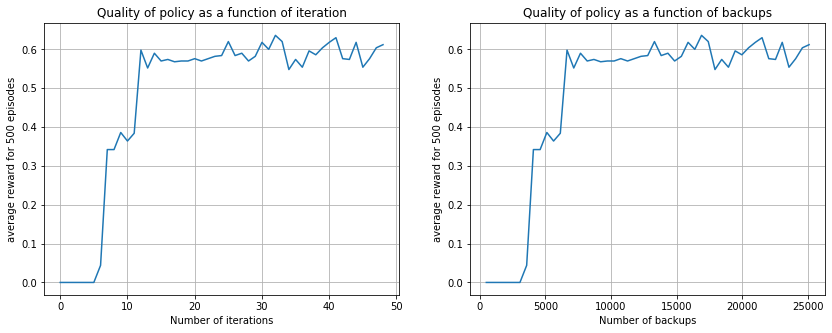

In [336]:
#backups_MPI = [SA+(env.nS*i) for i in steps_PE]
backups_MPI = []
previous = 0
for i in steps_MPE:
    backups_MPI.append(previous + (SA+env.nS*i))
    previous = backups_MPI[-1]

plot_graphs(np.arange(steps_MPI),backups_MPI ,avg_reward_MPI)

We can see that the number of iterations required for MPI to converge is around 50 

However when we look in terms of backup operations required, It takes 25,000 backups which is approximately same as PI

#### Conclusion :

Different algorithms might take different number of iterations to converge but the total number of operations (bellman) might be different. The correct measure of time taken is given by the total number of backup operations required.